#Table of Contents
* [1. El uso de Python como apoyo al pesaje de vehículos de pesados en movimiento (WIM)](#1.-El-uso-de-Python-como-apoyo-al-pesaje-de-vehículos-de-pesados-en-movimiento-%28WIM%29)
* [2. Descripción del proyecto](#2.-Descripción-del-proyecto)
* [3. Adquisición de datos](#3.-Adquisición-de-datos)
	* [3.1 Uso de datos sintéticos](#3.1-Uso-de-datos-sintéticos)
* [4. Almacenamiento y flujo de lo datos](#4.-Almacenamiento-y-flujo-de-lo-datos)
* [5. Filtrado de señal](#5.-Filtrado-de-señal)
* [6. Clasificación de vehículos](#6.-Clasificación-de-vehículos)
* [7. Calibración de los cálculos de pesaje](#7.-Calibración-de-los-cálculos-de-pesaje)
* [8. Reconocimiento automático de matrículas vehículares](#8.-Reconocimiento-automático-de-matrículas-vehículares)
* [9. Conclusión](#9.-Conclusión)


<!--bibtex

@TechReport{tech:optimization-vehicle-classification,
  Title                    = {Optimization Vehicle Classification},
  Author                   = {van Boxel, DW and van Lieshout, RA},
  Institution              = {Ministerie van Verkeer en Waterstaat - Directoraat-Generaal Rijkswaterstaat - Dienst Weg- en Waterbouwkunde (DWW)},
  Year                     = {2003},

  Owner                    = {xmn},
  Timestamp                = {2014.10.22}
}

@Article{pattern-recogntion-of-strings,
  Title                    = {Pattern recognition of strings with substitutions, insertions, deletions and generalized transpositions},
  Author                   = {Oommen, B John and Loke, Richard KS},
  Journal                  = {Pattern Recognition},
  Year                     = {1997},
  Number                   = {5},
  Pages                    = {789--800},
  Volume                   = {30},

  Publisher                = {Elsevier}
}

@article{vanweigh,
  title={Weigh-in-Motion--Categorising vehicles},
  author={van Boxel, DW and van Lieshout, RA and van Doorn, RA}
}


-->

<!-- %%javascript
IPython.load_extensions('calico-document-tools'); -->

# 1. El uso de Python como apoyo al pesaje de vehículos de pesados en movimiento (WIM)

Muchos accidentes en carreteras son causados, directamente o indirectamente, por vehículos pesados conducidos con sobrepeso. Estos damnifican más el pavimento y también sufren más efectos dinámicos durante las curvas.

Para inhibir el exceso de peso de los vehículos pesados, es necesario fiscalizar estas infracciones y, cuando necesario, aplicar las medidas establecidas por ley, como multas y aprehensiones. Un método que está siendo investigado en muchas partes del mundo es el pesaje en movimiento. Este método tiene como ventajas la economía en espacio físico y operación, ya que sus sensores son implantados en la propia carretera, y no implica en atrasos directos en el flujo de la vía, pues puede pesar los camiones transitando en alta velocidad.

En este trabajo será presentado las tecnologías utilizadas en el proyecto desarrollado en el laboratorio de transportes (**LabTrans**) de la Universidade Federal de Santa Catarina (**UFSC**). El trabajo aquí presentado está basado en este proyecto, pero desarrollado con carácter educativo.

El lenguaje Python es potenciado por las innumerables librerías de apoyo que le proporciona un mejor desempeño (a veces muy cerca de lenguajes como C y Java) y mayor comodidad para manipular los datos (como en el lenguaje R).

Las librerías principales utilizadas en este proyecto fueron: **numpy, scipy, flask, pandas, pandasql, sqlalchemy, statsmodels, numba, pymodelfit, scikit-learn, pydaqmx**.


# 2. Descripción del proyecto


Un sistema computacional de pesaje de vehículos en movimiento está compuesto, básicamente, de:
- Adquisición de señal de los sensores de peso en la vía);
- Segmentación de señal (para recortar la señal respectiva al camión medido);
- Tratamiento de señales;
- Cálculos (velocidad, número de ejes, grupos de ejes, distancia entre ejes, peso total, peso por ejes, peso por grupo de ejes, largo);
- Clasificación del vehículo;
- Calibración;
- Reconocimiento de matrículas vehiculares;
- Detección de infracción;

El sistema debe ser rápido y robusto para procesar todas estas informaciones en el menor tiempo posible. Python no es un lenguaje reconocido por tener un alto desempeño, por eso, es necesario utilizar librerías y métodos para potenciar su capacidad de procesamiento.

Con base en los resultados del pesaje, clasificación y reconocimiento de la matrícula vehicular es posible saber si el vehículo cometió alguna infracción y, en caso positivo, es posible vincular la infracción a la identificación del vehículo infractor.

In [4]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import numba as nb
import sqlalchemy
import psycopg2
import os
import sys

# local
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from pywim.lib.daq.generic import (
    gen_synthetic_analog_data, gen_synthetic_digital_data
)

try:
    import PyDAQmx as pydaq
except NotImplementedError:
    print('Usando DAQ genérico')
    import pywim.lib.daq.generic as pydaq

%matplotlib inline

Usando DAQ genérico


# 3. Adquisición de datos

La adquisición de datos fue hecha através de placas de adquisición DAQmx de la empresa National Instruments (**NI**). Para comunicar con estas fue utilizada la librería PyDAQmx, un wrap hecho en Python para los controladores del hardware fornecidos por la empresa. Esta librería es una interfaz completa para los controladores NIDAQmx ANSI C e importa todas las funciones del controlador e importa todas las constantes predefinidas. Como resultado, la librería retorna un objeto "numpy.array".

Después de adquirir la señal de los sensores, el sistema la almacena en un buffer circular en memoria que, dentro un proceso paralelo, es analisada en busca de una señal completa de un vehículo (segmento). Este proceso fue construído de manera muy simple, donde el programa espera la señal desde un bucle inductivo y, cuando accionado, segmenta la señal con valores respectivos a los 3 segundos siguientes.

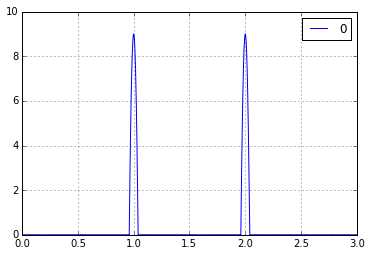

In [3]:
task = pydaq.Task()

samples_per_channel = 1000
number_of_channels = 1

task.CfgSampClkTiming()
total_samples = pydaq.int32()
data_size = samples_per_channel * number_of_channels
data = np.zeros((data_size,), dtype=np.float64)

task.StartTask()

data = task.ReadAnalogF64(
    samples_per_channel,
    10.0,
    pydaq.DAQmx_Val_GroupByChannel,
    data,
    data_size,
    pydaq.byref(total_samples),
    None
)

pd.DataFrame(data).plot()
plt.show()

## 3.1 Uso de datos sintéticos

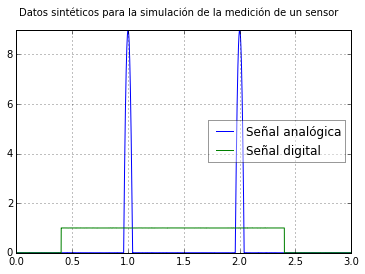

In [26]:
ts_analog = gen_synthetic_analog_data(5000, 3.0, 1)
ts_analog.plot(label='Señal analógica')

ts_digital = gen_synthetic_digital_data(5000, 3.0, 1)
ts_digital.plot(label='Señal digital')

plt.suptitle('Datos sintéticos para la simulación de la medición de un sensor')
plt.autoscale(tight=True)

leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.4)

plt.show()

# 4. Almacenamiento y flujo de lo datos

Después de segmentados, los datos brutos son almacenados en la base de datos, posibilitando cambiar los métodos de cálculos o parámetros de calibración, a cualquier momento de la ejecución del proyecto, a fin de obtener el mejor resultado.

En todos los métodos y funciones de cálculos en el sistema, el tipo patrón para los conjuntos de datos es el "pandas.DataFrame". Este es utilizado desde el momento de la lectura en la base de datos, en conjunto con sqlalchemy, hasta en los cálculos, ploteos y grabación en base de datos o en archivos CSV. el "pandas.DataFrame" fornece mecanismos para manipulación de datos muy parecidos a los utilizados en el lenguaje R.

# 5. Filtrado de señal

Para la realización de los cálculos, la señal necesita ser tradada (filtro de señal) y, para eso, fue aplicado un filtro pasa baja de órden 1, a 600 Hz, utilizando los métodos filtfilt y butterworth de la librería scipy. En esta etapa, los datos ya están almacenados en un objeto "pandas.DataFrame".

# 6. Clasificación de vehículos

Em método utilizado para la clasificación vehicular fue basado en los trabajos de <a name="ref-1"/>[(vanBoxel and vanLieshout, 2003)](#cite-tech:optimization-vehicle-classification) y <a name="ref-2"/>[(Oommen and Loke, 1997)](#cite-pattern-recogntion-of-strings)

En este método, es utilizado un conjunto de *layouts* de referencias, definido por un conjunto de símbolos, que representa el diseño del vehículo, como puede ser visto en la figura abajo.

<figure>
  <img src="img/dww-layout.png" alt="Ejemplos de layout de vehículos"/>
  <center><figcaption>Ejemplo de *layouts* de la representación de clases de vehículos pesados <a name="ref-3"/>[(vanBoxel and vanLieshout, 2003)](#cite-tech:optimization-vehicle-classification)</figcaption></center>
</figure>

Para clasificar el vehículo, el sistema crea un *layout* para el vehículo medido, lo compara con *layouts* de referencias y clasifica el vehículo que con el *layout* de referencia que resulta más próximo.

Este método presentava muy bajo desempeño con el lenguaje Python. Para solucionar esto, fue utilizada la librería numba, llegando a ser cerca de 100 veces más rápido. Fue necesária una adaptación en el algoritmo donde, ante de hacer las comparaciones, el *layout* del veículo y el *layout* de la clase de referencia son convertidos en números, así la función de comparación puede ser marcada para ser compilada en modo **nopython**. Cuanto más cerca de 0 más cerca el layout del vehículo está del *layout* de referencia.

In [24]:
from pywim.lib.vehicular_classification import dww
from pywim.lib.vehicular_classification import dww_nb

layout = dww.layout_to_int(dww.layout((7, 2, 0.5, 2)))
layout_ref = dww.layout_to_int('-O----O-O----O-')

z = np.zeros((len(layout), len(layout_ref)), dtype=int)

%time dww.D(layout, layout_ref, z)
%time resultado = dww_nb.D(layout, layout_ref, z)

print(resultado)

CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 1.65 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 33.1 µs
0


# 7. Calibración de los cálculos de pesaje

La calibración períodicas en sistemas de pesaje es muy importante para mantener un bajo margen de errores de los pesos calculados. Para apoyar esta etapa fue utilizado el método de regresión lineal por mínimos cuadrados (OLS) de la librería "statsmodels" que, por ejemplo, posibilita saber informaciones como el coeficiente de determinación (R²) resultante de la regresión lineal. La librería scikit-learn también fue utilizada en esta etapa con finalidad de apoyo en la análisis de los resultados. Através de los datos de peso calculados para cada sensor (en el tramo reservado para los sensores piezoeléctrico cuarzo fueron instaladas 16 líneas de sensores), fueron eligidos algunos modelos matemáticos en scikit-learn para predecir el valor del peso bruto total (el sistema calcula através de media ponderada). Através de esta librería, es posible medir y evaluar los resultados de los modelos y, posteriormente, compararlos entre sí.

# 8. Reconocimiento automático de matrículas vehículares

El reconocimiento de matrículas vehiculares fue realizado através de una cámara ALPR, de la empresa ARH. Con finalidad de medir la eficiencia de los resultados, fueron probadas algunas librerías libres para el tema. Uno de los materiales más interesantes encontrados a respecto fue el trabajo del investigador K.M. Sajjad (Automatic License Plate Recognition using Python and OpenCV) que fornece informaciones y ejemplos de cómo hacer el reconocimiento de matrículas vehículares utilizando el lenguaje Python.

# 9. Conclusión

#References

<a name="cite-tech:optimization-vehicle-classification"/><sup>[^](#ref-1) [^](#ref-3) </sup>van Boxel, DW and van Lieshout, RA. 2003. _Optimization Vehicle Classification_.

<a name="cite-pattern-recogntion-of-strings"/><sup>[^](#ref-2) </sup>Oommen, B John and Loke, Richard KS. 1997. _Pattern recognition of strings with substitutions, insertions, deletions and generalized transpositions_.

